In [1]:
import pickle
import os

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [2]:
with open('/home/ilharco/Desktop/data/all_data', 'rb') as f:
    data = pickle.load(f)

In [3]:
ylims = {
    'cola': (-0.1, 0.7),
    'mrpc': (0.0, 1.0),
    'sst': (0.4, 1.0)
}

perf = {
    'cola': 'mcc',
    'mrpc': 'acc_and_f1',
    'sst': 'acc'
}

In [4]:
### MAX OUT
for task in data.keys():
    for init_seed in data[task].keys():
        for data_seed in data[task][init_seed].keys():
            for idx in range(1, len(data[task][init_seed][data_seed][perf[task]]['during'])):
                data[task][init_seed][data_seed][perf[task]]['during'][idx][1] = max(
                    data[task][init_seed][data_seed][perf[task]]['during'][idx][1],
                    data[task][init_seed][data_seed][perf[task]]['during'][idx-1][1])

In [ ]:
for task in ['mrpc', 'sst', 'cola']:
    for xlim in [None, 100, 200]:

        num_init_seeds = len(data[task].keys())
        assert num_init_seeds %2 == 0

        num_init_seeds_by2 = num_init_seeds//2
        fig, axs = plt.subplots(2, num_init_seeds_by2, figsize=(25,10))
        fig.suptitle(task)

        for init_seed in range(1, num_init_seeds+1):
            for data_seed in range(1, len(data[task][init_seed].keys())+1):
                local_data = np.array(data[task][init_seed][data_seed][perf[task]]['during'])
                xs = local_data[:, 0]
                ys = local_data[:, 1]

                ax = axs[(init_seed-1) // num_init_seeds_by2][(init_seed-1) % num_init_seeds_by2]
                ax.plot(xs, ys)
                ax.set_ylim(ylims[task])
                if xlim:
                    ax.set_xlim(0,xlim)
                ax.set_xlabel('Num batches')
                ax.set_ylabel('Val performance')
                ax.set_title('Init seed %d' % init_seed)

        filename = '/home/ilharco/Desktop/data/init_' + task
        if xlim: filename += '_' + str(xlim)
        plt.savefig(filename + '.png', bbox_inches='tight')

In [ ]:
for task in ['mrpc', 'sst', 'cola']:
    for xlim in [None, 100, 200]:
        num_data_seeds = len(data[task][1].keys())
        assert num_data_seeds %2 == 0

        num_data_seeds_by2 = num_data_seeds//2
        fig, axs = plt.subplots(2, num_data_seeds_by2, figsize=(25,10))
        fig.suptitle(task)

        for data_seed in range(1, num_data_seeds+1):
            for init_seed in range(1, len(data[task].keys())+1):
                local_data = np.array(data[task][init_seed][data_seed][perf[task]]['during'])
                xs = local_data[:, 0]
                ys = local_data[:, 1]

                ax = axs[(data_seed-1) // num_data_seeds_by2][(data_seed-1) % num_data_seeds_by2]
                ax.plot(xs, ys)
                ax.set_ylim(ylims[task])
                if xlim:
                    ax.set_xlim(0,xlim)
                ax.set_xlabel('Num batches')
                ax.set_ylabel('Val performance')
                ax.set_title('Data seed %d' % data_seed)

        filename = '/home/ilharco/Desktop/data/data_' + task
        if xlim: filename += '_' + str(xlim)
        plt.savefig(filename + '.png', bbox_inches='tight')

In [13]:
from scipy import stats
import scipy
import collections

In [ ]:
for task in ['cola', 'sst', 'mrpc']:
    for mode in ['spearman', 'pearson']:

        batches = np.array(data[task][1][1][perf[task]]['during'])[:, 0]

        data_per_batch = collections.defaultdict(list)

        for init_seed in data[task].keys():
            for data_seed in data[task][init_seed].keys():
                for [b, v] in data[task][init_seed][data_seed][perf[task]]['during']:
                    data_per_batch[b].append(v)

        matrix = {}
        for b1 in batches:
            matrix[b1] = {}
            b1_vals = data_per_batch[b1]
            for b2 in batches:
                b2_vals = data_per_batch[b2]
                fn = scipy.stats.spearmanr if mode == 'spearman' else scipy.stats.pearsonr
                matrix[b1][b2] = fn(b1_vals, b2_vals)

        m = np.zeros((len(batches), len(batches)))
        for i1, b1 in enumerate(batches):
            for i2, b2 in enumerate(batches):
                m[i1][i2] = matrix[b1][b2][0]
        
        
        plt.matshow(m, vmin=-1.0, vmax=1.0, cmap='seismic')
        plt.colorbar()
        plt.title(task + ' - ' + mode)
        filename = '/home/ilharco/Desktop/data/' + mode + '_' + task
        plt.savefig(filename + '.png', bbox_inches='tight')

In [51]:
task = 'sst'
batches = np.array(data[task][1][1][perf[task]]['during'], dtype=np.int)[:, 0]
interval = batches[-1] - batches[-2]

In [52]:
batches = list(batches)
np.array(batches, dtype=np.int)

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    60,    70,    80,
          90,   100,   110,   120,   130,   140,   150,   160,   170,
         180,   190,   200,   210,   220,   230,   240,   250,   260,
         270,   280,   290,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4210,  4310,
        4410,  4510,  4610,  4710,  4810,  4910,  5010,  5110,  5210,
        5310,  5410,

In [53]:
np.shape(m)

(201, 201)

In [54]:
for m_i in range(len(m)):
    for i, b in enumerate(batches):
        

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4210,
 4310,
 4410,
 4510,
 4610,
 4710,
 4810,
 4910,
 5010,
 5110,
 5210,
 5310,
 5410,
 5510,
 5610,
 5710,
 5810,
 5910,
 6010,
 6110,
 6210,
 6310,
 6410,
 6510,
 6610,
 6710,
 6810,
 6910,
 7010,
 7110,
 7210,
 7310,
 7410,
 7510,
 7610,
 7710,
 7810,
 7910,
 8010,
 8110,
 8210,
 8310,
 8410,
 8420,
 8520,
 8620,
 8720,
 8820,
 8920,

In [47]:
mode = 'spearman'
batches = np.array(data[task][1][1][perf[task]]['during'])[:, 0]

data_per_batch = collections.defaultdict(list)

for init_seed in data[task].keys():
    for data_seed in data[task][init_seed].keys():
        for [b, v] in data[task][init_seed][data_seed][perf[task]]['during']:
            data_per_batch[b].append(v)

matrix = {}
for b1 in batches:
    matrix[b1] = {}
    b1_vals = data_per_batch[b1]
    for b2 in batches:
        b2_vals = data_per_batch[b2]
        fn = scipy.stats.spearmanr if mode == 'spearman' else scipy.stats.pearsonr
        matrix[b1][b2] = fn(b1_vals, b2_vals)

m = np.zeros((len(batches), len(batches)))
for i1, b1 in enumerate(batches):
    for i2, b2 in enumerate(batches):
        m[i1][i2] = matrix[b1][b2][0]

<IPython.core.display.Javascript object>


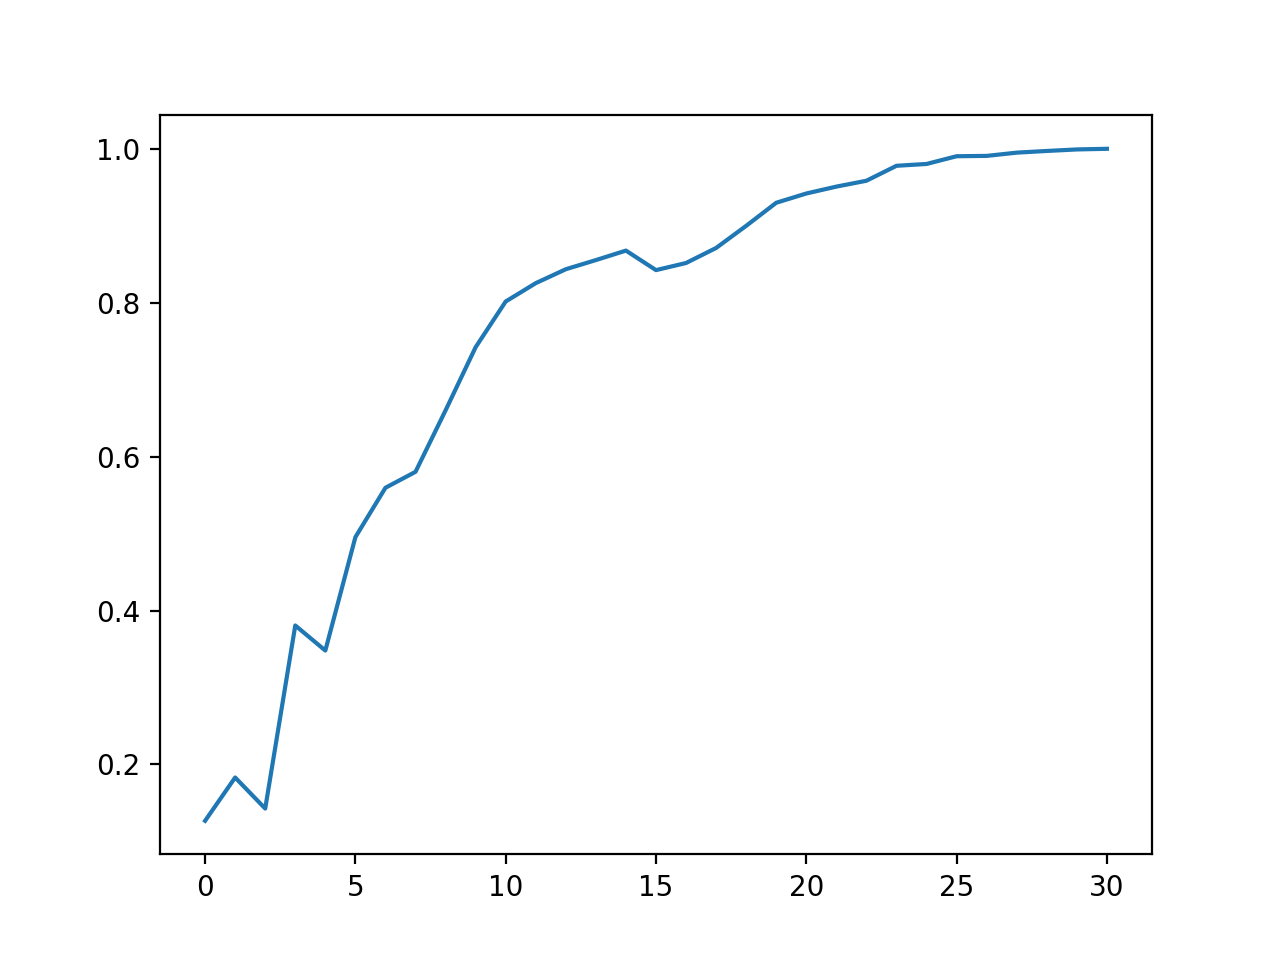

In [48]:
plt.figure()
plt.plot(norm_vals)
plt.show()